In [10]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear

from panther.nn import SKLinear

In [11]:
# Load the dataset
data = pd.read_csv("../datasets/diabetes[1].csv")
X = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
# Add quadratic features
X_quad = torch.cat(
    [
        X,
        X**2,
        X**3,
        X**4,
        X**5,
        X**6,
        X**7,
        X**8,
        X,
        X**2,
        X**3,
        X**4,
        X**5,
        X**6,
        X**7,
        X**8,
        X,
        X**2,
        X**3,
        X**4,
        X**5,
        X**6,
        X**7,
        X**8,
        X,
        X**2,
        X**3,
        X**4,
        X**5,
        X**6,
        X**7,
        X**8,
    ],
    dim=1,
)
y = torch.tensor(data.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)

In [12]:
# Define the training function
def train_model(model, criterion, optimizer, X, y, epochs=200):
    model.train()
    losses = []
    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses


# Define the timing function
def time_model(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        # Time inference
        start_time = time.time()
        outputs = model(X)
        inference_time = time.time() - start_time

    # Time backpropagation
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    start_time = time.time()
    loss.backward()
    backprop_time = time.time() - start_time

    return inference_time, backprop_time

In [13]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LinearModel, self).__init__()
        self.layer1 = Linear(in_features=input_dim, out_features=hidden_dim)
        self.layer2 = Linear(in_features=hidden_dim, out_features=output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x


class SKLinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SKLinearModel, self).__init__()
        self.layer1 = SKLinear(
            input_dim=input_dim,
            output_dim=hidden_dim,
            num_terms=3,
            low_rank=8,
            bias_init_std=0.01,
        )
        self.layer2 = Linear(in_features=hidden_dim, out_features=output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x.T))
        x = self.sigmoid(self.layer2(x.T))
        return x

In [14]:
# Initialize models, criterion, and optimizers
input_dim = X_quad.shape[1]
hidden_dim = 64
output_dim = 1

linear_model = LinearModel(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
).cuda()
sklinear_model = SKLinearModel(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
).cuda()

criterion = nn.BCELoss()
linear_optimizer = optim.SGD(linear_model.parameters(), lr=0.01)
sklinear_optimizer = optim.SGD(sklinear_model.parameters(), lr=0.01)

# Replace inf values with a large finite number
X_quad = torch.nan_to_num(X_quad, nan=0.0, posinf=1e6, neginf=-1e6)

# Train both models
linear_losses = train_model(
    linear_model, criterion, linear_optimizer, X_quad.cuda(), y.cuda()
)
sklinear_losses = train_model(
    sklinear_model, criterion, sklinear_optimizer, X_quad.cuda(), y.cuda()
)

In [15]:
# Time both models
linear_inference_time, linear_backprop_time = time_model(
    linear_model, X_quad.cuda(), y.cuda(), criterion
)
sklinear_inference_time, sklinear_backprop_time = time_model(
    sklinear_model, X_quad.cuda(), y.cuda(), criterion
)

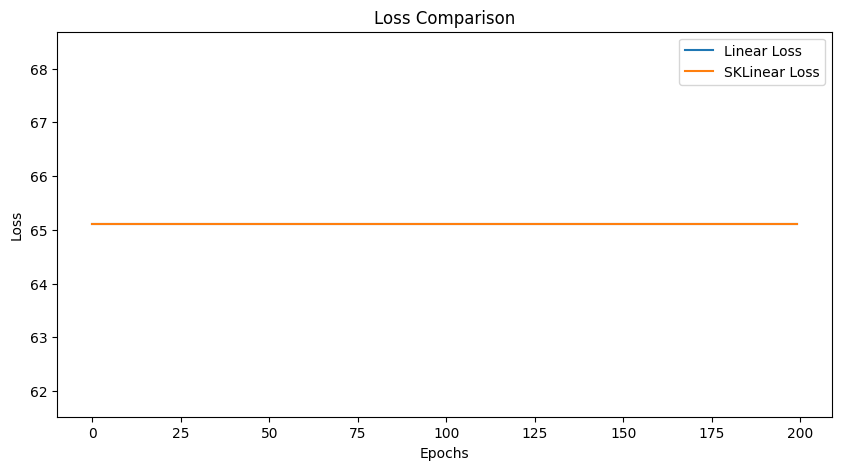

In [16]:
# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(linear_losses, label="Linear Loss")
plt.plot(sklinear_losses, label="SKLinear Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

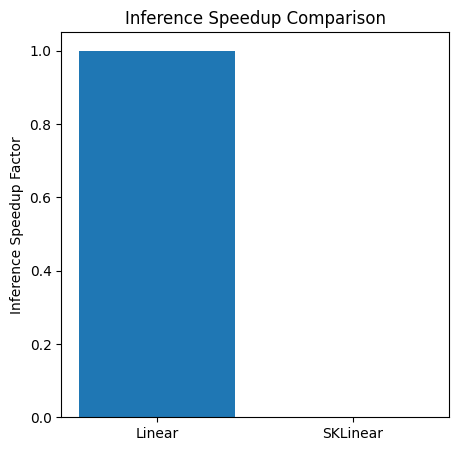

In [17]:
# Plot the speedup graph for inference
inference_speedup = linear_inference_time / sklinear_inference_time
plt.figure(figsize=(5, 5))
plt.bar(["Linear", "SKLinear"], [1, inference_speedup])
plt.ylabel("Inference Speedup Factor")
plt.title("Inference Speedup Comparison")
plt.show()

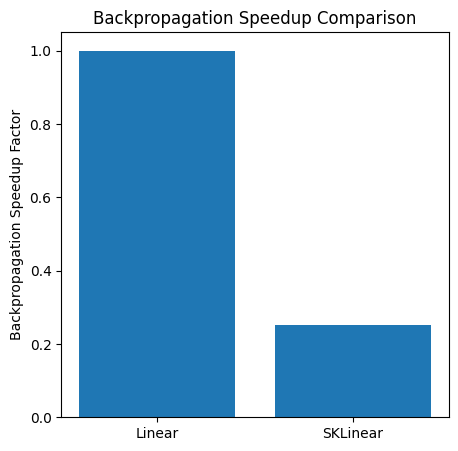

In [18]:
# Plot the speedup graph for backpropagation
backprop_speedup = linear_backprop_time / sklinear_backprop_time
plt.figure(figsize=(5, 5))
plt.bar(["Linear", "SKLinear"], [1, backprop_speedup])
plt.ylabel("Backpropagation Speedup Factor")
plt.title("Backpropagation Speedup Comparison")
plt.show()